## Setup & Imports

In [27]:
import os
import torch
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import json

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Dataset Paths & Image Transformations and Extracting Unique Color Classes


In [28]:
val_dir = '/kaggle/input/ayna-dataset/dataset/validation'
train_dir = '/kaggle/input/ayna-dataset/dataset/training'

val_inputs_dir = os.path.join(val_dir, 'inputs')
train_json = os.path.join(train_dir, 'data.json')

img_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

def get_unique_colors(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    unique_colors = set(entry['colour'] for entry in data)
    return sorted(unique_colors)

ALL_COLORS = get_unique_colors(train_json)
COLOR_DIM = len(ALL_COLORS)

print(f"Unique colors: {ALL_COLORS}")
print(f"Color dimension for one-hot: {COLOR_DIM}")

def color_to_onehot(color):
    idx = ALL_COLORS.index(color)
    vec = torch.zeros(COLOR_DIM)
    vec[idx] = 1.0
    return vec

Unique colors: ['blue', 'cyan', 'green', 'magenta', 'orange', 'purple', 'red', 'yellow']
Color dimension for one-hot: 8


## Conditional U-Net Model

In [29]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, use_dropout=False):
        super().__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True)
        ]
        if use_dropout:
            layers.append(nn.Dropout(0.3))
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)


class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, color_dim=8): 
        super().__init__()
        self.color_dim = color_dim

        # Encoder
        self.enc1 = DoubleConv(in_channels + color_dim, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck with dropout
        self.bottleneck = DoubleConv(512, 1024, use_dropout=True)

        # Decoder with dropout
        self.up5 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec5 = DoubleConv(1024, 512, use_dropout=True)
        self.up6 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec6 = DoubleConv(512, 256)
        self.up7 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec7 = DoubleConv(256, 128)
        self.up8 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec8 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, 1)
        self.sigmoid = nn.Sigmoid()

        self._initialize_weights()

    def forward(self, x, color_onehot):
        color_expanded = color_onehot.unsqueeze(2).unsqueeze(3).expand(-1, -1, x.shape[2], x.shape[3])
        x = torch.cat([x, color_expanded], dim=1)

        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        e4 = self.enc4(p3)
        p4 = self.pool4(e4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder with skip connections
        d5 = self.up5(b)
        d5 = torch.cat([d5, e4], dim=1)
        d5 = self.dec5(d5)
        d6 = self.up6(d5)
        d6 = torch.cat([d6, e3], dim=1)
        d6 = self.dec6(d6)
        d7 = self.up7(d6)
        d7 = torch.cat([d7, e2], dim=1)
        d7 = self.dec7(d7)
        d8 = self.up8(d7)
        d8 = torch.cat([d8, e1], dim=1)
        d8 = self.dec8(d8)

        out = self.final_conv(d8)
        return self.sigmoid(out)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)


## Load Pretrained Model and inference function

In [30]:
model = ConditionalUNet()
model.load_state_dict(torch.load("/kaggle/input/unet_polygon_model/pytorch/default/1/unet_polygon_model.pth", map_location=device))
model.to(device)
model.eval()
# Example inference function
def infer(model, input_img_path, color_name):
    input_img = Image.open(input_img_path).convert('RGB')
    input_tensor = img_transform(input_img).unsqueeze(0).to(device)
    color_onehot = color_to_onehot(color_name).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor, color_onehot)
    output_img = transforms.ToPILImage()(output.squeeze(0).cpu())

    # Visualize
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Polygon")
    plt.imshow(input_img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Generated Output ({color_name})")
    plt.imshow(output_img)
    plt.axis('off')
    plt.show()


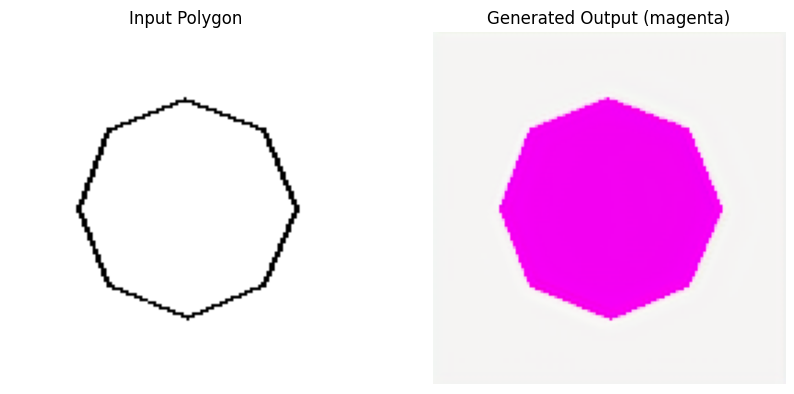

In [34]:
example_input = os.path.join(val_inputs_dir, 'octagon.png') 
example_color = 'magenta'  
infer(model, example_input, example_color)